# Plots of 50% detection rate

## Imports and basic definitions

First we import the basic things.

In [11]:
from math import sqrt, cos, pi, exp, factorial, log
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.5, 4.5)

Then we import the radar link functions which are defined in `radarlink.py`.

In [12]:
from radarlink import *

To find the 50% point in the probability curves, we need a binary search function. We also define a version of the `sign` function that always returns an integer, to ensure that the signs of floats and integers compare properly (this is a bit crude).

The `binsearch` function starts with the range $[a,b]$ and does a binary search, narrowing the range around the zero until the difference $|a-b| < \varepsilon$.

In [13]:
def isign(x):
    return int(np.sign(x))


def binsearch(f, a, b, eps=1):
    middle = (a+b)/2
    fa = f(a) * 1.0
    fb = f(b) * 1.0
    if isign(fa) == isign(fb):
        raise ValueError("initial signs match")
    while np.abs(b-a) > eps:
        middle = (a+b)/2
        fm = f(middle)
        if isign(fm) != isign(fa):
            b = middle
            fb = fm
        elif isign(fm) != isign(fb):
            a = middle
            fa = fm
        else:
            raise ValueError("unexpected error")
    return middle

The following function is used for formatting the log scale axis ticks of plots. Matplotlib's built-in one has some problems with numbers less than 1.

In [14]:
from matplotlib.ticker import FuncFormatter
def myLogFormat(y, pos):
    # Find the number of decimal places required
    decimalplaces = int(np.maximum(-np.log10(y),0))     # =0 for numbers >=1
    # Insert that number into a format string
    formatstring = '{{:.{:1d}f}}'.format(decimalplaces)
    # Return the formatted tick label
    return formatstring.format(y)


## Laser parameters

We define the lasers as before: current laser at green and IR wavelength, and the Graz 80 mJ green laser.

In [15]:
green_laser = {
    "pulse_energy" : 0.4e-3, # Joules
    "wavelength" : 532e-9, # meters
    "eta_q" : 0.25,
    "aperture" : 0.188, # square meters
    "eta_t" : get_eta_t(),
    "eta_r" : get_eta_r(),
    "gain" : gain(2.5, 2.5),
    "fire_rate" : 2000,
    "plot_color" : "C2",
    "f_atmos" : T_atmos_func("green", "standard"),
    "t_cirrus" : 1.3
}

IR_laser = {
    "pulse_energy" : 0.8e-3, # Joules
    "wavelength" : 1064e-9, # meters
    "eta_q" : 0.25,
    "aperture" : 0.188, # square meters
    "eta_t" : get_eta_t(),
    "eta_r" : get_eta_r(),
    "gain" : gain(2.5, 2.5),
    "fire_rate" : 2000,
    "plot_color" : "C3",
    "f_atmos" : T_atmos_func("IR", "standard"),
    "t_cirrus" : 1.3
}

new_laser = {
    "pulse_energy" : 80e-3, # Joules
    "wavelength" : 532e-9, # meters
    "eta_q" : 0.20,
    "aperture" : 0.188, # square meters
    "eta_t" : get_eta_t(),
    "eta_r" : get_eta_r(),
    "gain" : gain(2.5, 2.5),
    "fire_rate" : 200,
    "plot_color" : "C0",
    "f_atmos" : T_atmos_func("green", "standard"),
    "t_cirrus" : 1.3
}


lasers = {
    "Green" : green_laser,
    "IR" : IR_laser,
    "Upgrade" : new_laser
}

electrons_per_detection = 2
detections_per_second = 6
station_altitude = 64.5

## Computation


We want to compute the altitudes and cross sections where the detection probability falls below 50% for a given cross section.

We need a function that computes the probability given the laser properties, altitude, cross section and zenith angle.

In [16]:
def compute(laser, altitude, cross_section, theta_z):
    aperture = laser["aperture"]
    fire_rate = laser["fire_rate"]
    E = laser["pulse_energy"]
    lmd = laser["wavelength"]
    eta_t = laser["eta_t"]
    eta_r = laser["eta_r"]
    eta_q = laser["eta_q"]
    Gt = laser["gain"]
    T_atmos = laser["f_atmos"](theta_z)
    T_cirrus = cirrus_transmittance(laser["t_cirrus"], theta_z)
    
    R = slant_range(station_altitude, altitude, theta_z)
    ne = n_electrons(eta_q, E, lmd, eta_t, Gt, cross_section, R, aperture, eta_r, T_atmos, T_cirrus)
    p_single = pulse_probability(ne, electrons_per_detection)
    return detection_probability(fire_rate, detections_per_second, p_single)

### Altitude as a function of cross section

To find the 50% probability altitude at a given cross section, we use the binary search to find the zero on a function of the altitude, $f(h) = p(h)-0.5$. We start the search with a 0 to 10000 kilometer bracket and a 0.1 meter tolerance.

In [17]:
def altitude50(laser, cross_section, theta_z):
    def f(altitude):
        return compute(laser, altitude, cross_section, theta_z) - 0.5
    return binsearch(f, -1, 1e7, 0.1)


The plots are then generated by running the above computation for a range of cross sections. Separate figures are made for different $\theta_z$.

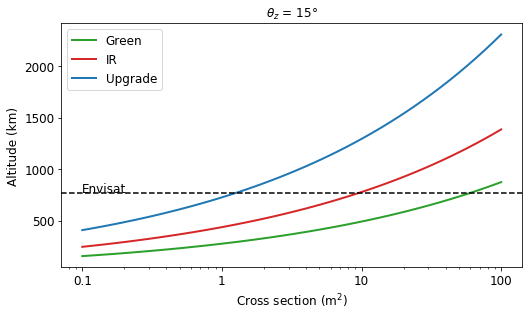

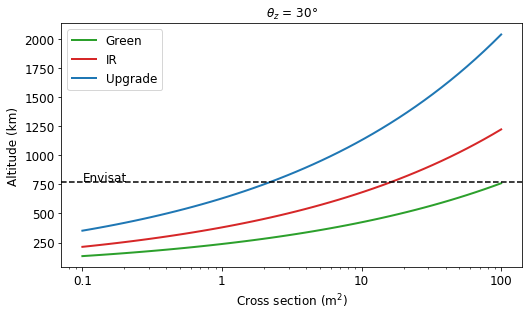

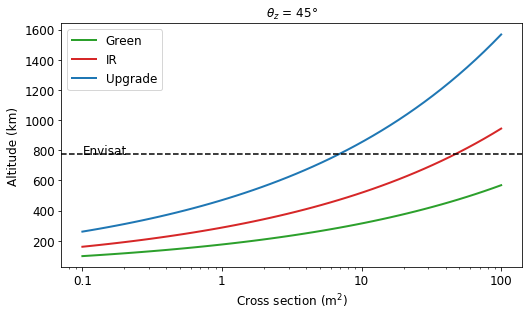

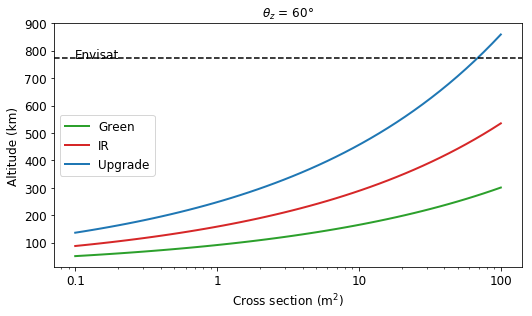

In [18]:
cross_sections = 10**np.linspace(log(0.1, 10), log(100.0, 10), 50)

for theta_z in [15, 30, 45, 60]:
    plt.figure()
    for name in lasers:
        output = [altitude50(lasers[name], A, theta_z)/1000 for A in cross_sections]
        plt.semilogx(cross_sections, output, "-", label=name, color=lasers[name]["plot_color"], linewidth=2)

    plt.axhline(773, color="black", linestyle="--")
    plt.text(0.1, 774, "Envisat", fontsize="large")
    plt.title("$\\theta_z$ = {}°".format(theta_z))
    plt.legend(fontsize="large")
    #plt.ylim(0, 1300)
    plt.xlabel("Cross section (m$^2$)", fontsize="large")
    plt.xticks(fontsize="large")
    plt.yticks(fontsize="large")
    plt.ylabel("Altitude (km)", fontsize="large")
    plt.gca().xaxis.set_major_formatter(FuncFormatter(myLogFormat))
    plt.tight_layout()
    plt.savefig("altitude50_{}.pdf".format(theta_z))
    plt.savefig("altitude50_{}.png".format(theta_z))

### Cross section as a function of altitude

Here we compute the minimum cross section to get a 50% detection rate at a given altitude. The process is the same as above, only the variables and their ranges change.

We start the binary search in a 0 to 10000 square meter bracket and use a 0.0001 square meter tolerance (to ensure good resolution in the logarithmic plot).

In [19]:
def cross_section50(laser, altitude, theta_z):
    def f(cross_section):
        return compute(laser, altitude, cross_section, theta_z) - 0.5
    return binsearch(f, 0, 1e15, 0.0001)

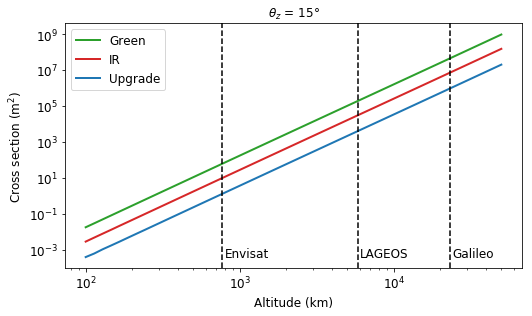

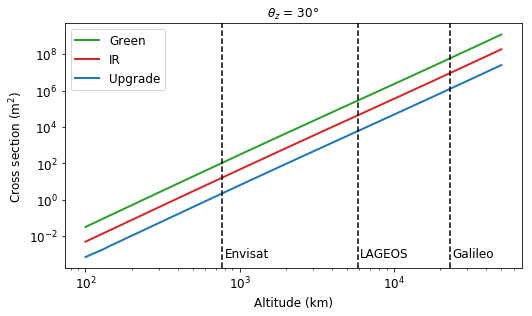

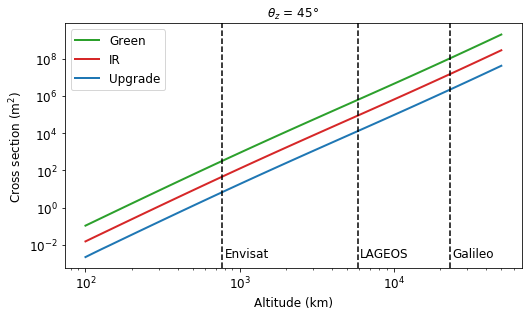

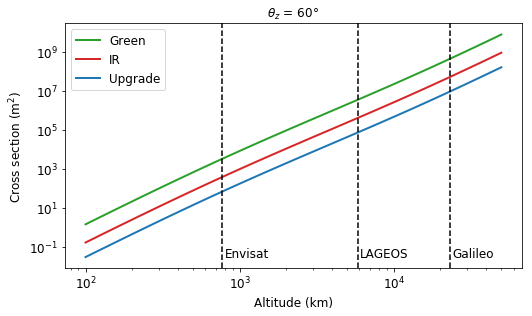

In [20]:
altitudes = 10**np.linspace(log(100, 10), log(50000, 10), 50) * 1000

for theta_z in [15, 30, 45, 60]:
    plt.figure()
    low = 1e20
    for name in lasers:
        output = np.array([cross_section50(lasers[name], h, theta_z) for h in altitudes])
        logA = np.log10(altitudes)
        logC = np.log10(output)
        #print((logC[-2]-logC[1]) / (logA[-2]-logA[1]))
        low = min(low, min(output))
        plt.loglog(altitudes/1000, output, "-", label=name, color=lasers[name]["plot_color"], linewidth=2)
    #plt.gca().yaxis.set_major_formatter(FuncFormatter(myLogFormat))
    plt.title("$\\theta_z$ = {}°".format(theta_z))
    plt.legend(loc="upper left", fontsize="large")
    plt.xlabel("Altitude (km)", fontsize="large")
    plt.ylabel("Cross section (m$^2$)", fontsize="large")
    plt.xticks(fontsize="large")
    plt.yticks(fontsize="large")
    
    plt.axvline(773, linestyle="--", color="black")
    plt.text(800, low, "Envisat", fontsize="large")
    plt.axvline(5900, linestyle="--", color="black")
    plt.text(6000, low, "LAGEOS", fontsize="large")
    plt.axvline(23222, linestyle="--", color="black")
    plt.text(24000, low, "Galileo", fontsize="large")
    plt.tight_layout()
    plt.savefig("cross50_{}.pdf".format(theta_z))
    plt.savefig("cross50_{}.png".format(theta_z))